In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
from datasets import DatasetDict

ds = load_dataset("Bingsu/Human_Action_Recognition")
ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 5400
    })
})

In [120]:
dsTrainTest = ds["train"].train_test_split(
    test_size=0.2, seed=42, stratify_by_column="labels"
)
dsTrainVal = dsTrainTest["train"].train_test_split(
    test_size=0.2, seed=42, stratify_by_column="labels"
)

dsUpdated = DatasetDict(
    {
        "train": dsTrainVal["train"],
        "valid": dsTrainVal["test"],
        "test": dsTrainTest["test"],
    }
)

dsUpdated

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8064
    })
    valid: Dataset({
        features: ['image', 'labels'],
        num_rows: 2016
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

In [5]:
dsUpdated["train"].features

{'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop'], id=None)}

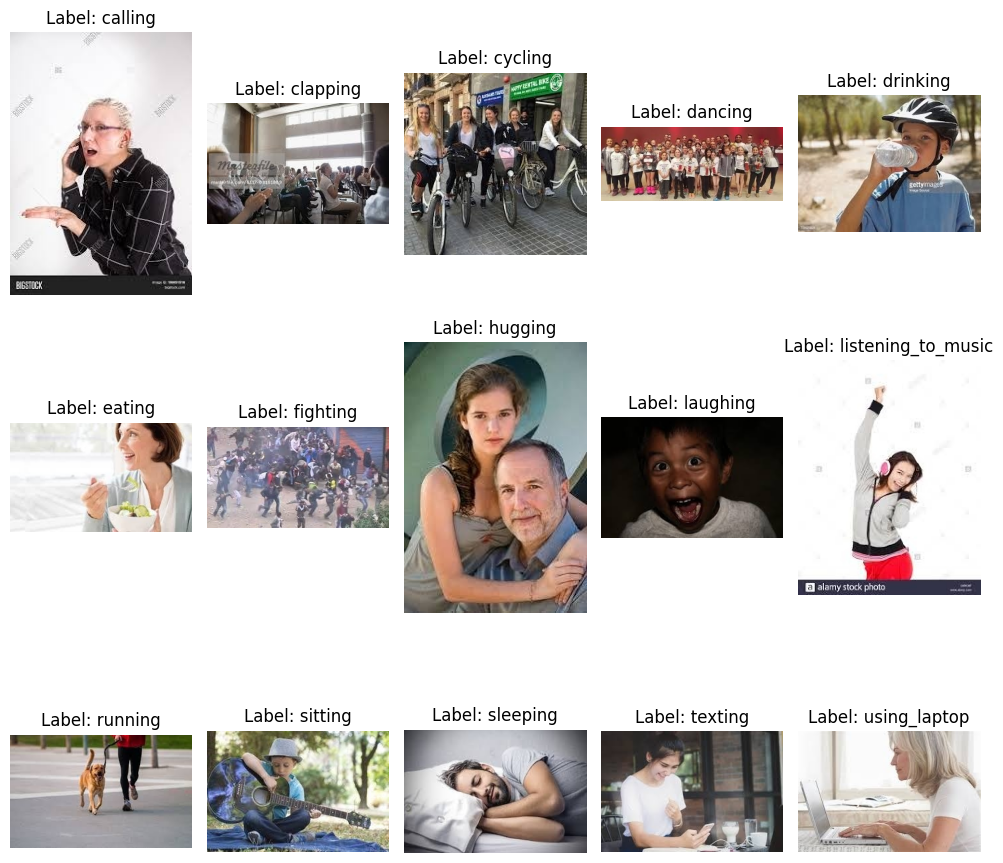

In [194]:
import matplotlib.pyplot as plt

labels = dsUpdated["train"].features["labels"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label


fig, axs = plt.subplots(3, 5, figsize=(10, 10))
labelId = 0

for i in range(len((dsUpdated["train"]))):
    img, lab = dsUpdated["train"][i].values()

    if lab == labelId:
        row = labelId // 5
        col = labelId % 5

        axs[row, col].imshow(img)
        axs[row, col].set_title(f"Label: {id2label[str(labelId)]}")
        axs[row, col].axis("off")

        labelId += 1

    if labelId > 14:
        break

plt.tight_layout()
plt.show()

In [6]:
classes = [
    "calling",
    "clapping",
    "cycling",
    "dancing",
    "drinking",
    "eating",
    "fighting",
    "hugging",
    "laughing",
    "listening_to_music",
    "running",
    "sitting",
    "sleeping",
    "texting",
    "using_laptop",
]

dsUpdated["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x168>,
 'labels': 5}

<Axes: title={'center': 'Human Activity'}>

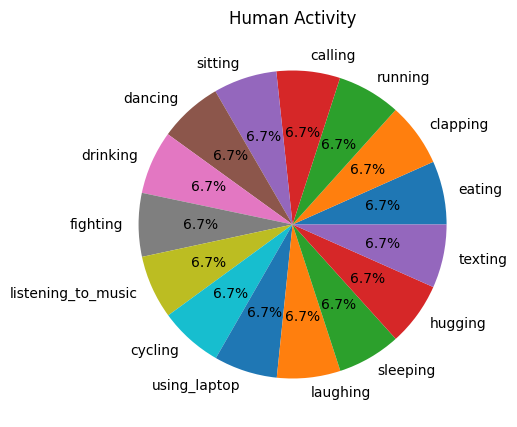

In [196]:
import pandas as pd

trainLabs = pd.Series(dsUpdated["train"]["labels"]).astype(str).map(id2label)
labelFreq = trainLabs.value_counts()
labelFreq.plot(kind="pie", figsize=(5, 5), title="Human Activity", autopct="%1.1f%%")

In [121]:
trainset = dsUpdated["train"]
validset = dsUpdated["valid"]
testset = dsUpdated["test"]

In [122]:
batchSize = 64


trainTransform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-45, 45)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.ToTensor(),
    ]
)

testTransform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Resize((224, 224)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.ToTensor(),
    ]
)


def train_collate(batch):
    images = torch.stack([trainTransform(item["image"]) for item in batch])
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)

    return [images, labels]


def test_collate(batch):
    images = torch.stack([testTransform(item["image"]) for item in batch])
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)

    return [images, labels]


trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batchSize, shuffle=True, collate_fn=train_collate
)

validloader = torch.utils.data.DataLoader(
    validset, batch_size=batchSize, shuffle=True, collate_fn=test_collate
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batchSize, shuffle=False, collate_fn=test_collate
)

model


In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    numBatches = len(dataloader)
    model.train()
    trainLoss = 0
    for batch, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        pred = model(imgs)

        loss = loss_fn(pred, labels)

        loss.backward()
        optimizer.step()

        trainLoss += loss.item()
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    trainLoss /= numBatches

    return round(trainLoss, 4)

In [14]:
##Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            pred = model(imgs)
            test_loss += loss_fn(pred, labels).item()
            _, pred = torch.max(pred.data, 1)

            correct += (pred == labels).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return {"val_loss": round(test_loss, 4), "val_acc": round(correct * 100, 2)}

In [15]:
def fit_and_evaluate(model, trainl, testl, loss_fn, optimizer, epochs=10):
    trainLosses = []
    testLosses = []
    results = []

    for t in range(epochs):
        print(f"Epoch {t+1}")
        trainLoss = train(trainl, model, loss_fn, optimizer)

        testDict = test(testl, model, loss_fn)
        testLoss = testDict["val_loss"]
        testAccuracy = testDict["val_acc"]

        trainLosses.append(trainLoss)
        testLosses.append(testLoss)
        results.append(
            {"train_loss": trainLoss, "val_loss": testLoss, "val_acc": testAccuracy}
        )

        print(trainLoss, testLoss, testAccuracy)

    print("------------------")
    print(f"Test Error: \n Accuracy: {testAccuracy}%, Avg loss: {testLoss} \n")

    return results

In [16]:
def plot_curves(history, epochs, acc=False):
    trainLosses = [x["train_loss"] for x in history]
    testLosses = [x["val_loss"] for x in history]

    # trainAccuracies = [i["accuracy"] for i in trainMetrics]
    testAccuracies = [x["val_acc"] for x in history]

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss curve")
    plt.xticks = range(1, epochs + 1)
    plt.locator_params(axis="x", integer=True)

    plt.plot(
        range(1, epochs + 1), trainLosses, label="Training loss", linestyle="dotted"
    )
    plt.plot(range(1, epochs + 1), testLosses, label="Test loss")

    # plt.plot(range(1, epochs + 1), trainAccuracies, label="Training accuracy")
    plt.plot(range(1, epochs + 1), testAccuracies, label="Test accuracy")

    plt.legend()
    plt.show()

In [178]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
class BaseNetClassifier(nn.Module):
    def __init__(self, ntargets=15):
        super(BaseNetClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, ntargets)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [197]:
baseNet = BaseNetClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

baseNet.to(device)

cuda:0


BaseNetClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=186624, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)

In [179]:
count_parameters(baseNet)

23909327

In [198]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseNet.parameters(), lr=0.001)

In [199]:
epochs = 20
baseNetHistory = []

baseNetHistory += fit_and_evaluate(
    baseNet, trainloader, validloader, criterion, optimizer, epochs
)

Epoch 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2.9609 2.7033 8.98
Epoch 2
2.6898 2.6685 11.46
Epoch 3
2.651 2.6616 9.47
Epoch 4
2.6051 2.6273 10.47
Epoch 5
2.5881 2.5973 11.61
Epoch 6
2.5659 2.5484 14.24
Epoch 7
2.5279 2.5462 13.1
Epoch 8
2.5015 2.5247 15.62
Epoch 9
2.4952 2.5018 16.22
Epoch 10
2.4773 2.4645 17.21
Epoch 11
2.4733 2.4765 16.72
Epoch 12
2.4677 2.4566 16.82
Epoch 13
2.4421 2.4991 17.11
Epoch 14
2.4443 2.3656 21.43
Epoch 15
2.4355 2.4654 18.15
Epoch 16
2.4176 2.5261 16.91
Epoch 17
2.3972 2.4155 20.78
Epoch 18
2.3821 2.3605 21.97
Epoch 19
2.3637 2.2954 24.4
Epoch 20
2.3494 2.3259 22.87
------------------
Test Error: 
 Accuracy: 22.87%, Avg loss: 2.3259 



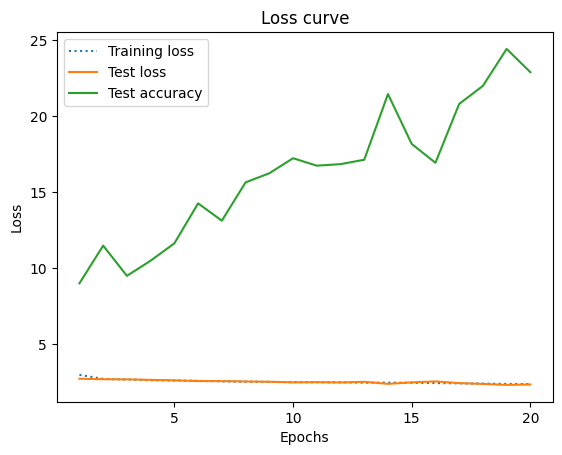

In [203]:
plot_curves(baseNetHistory, epochs)

In [204]:
baseNetTestResults = test(testloader, baseNet, criterion)

baseNetTestResults

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'val_loss': 2.3829, 'val_acc': 22.62}

In [24]:
torch.cuda.empty_cache()

In [18]:
class ModifiedNetClassifier(nn.Module):
    def __init__(self, ntargets=15):
        super(ModifiedNetClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        self.fc1 = nn.Linear(256 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, ntargets)

        self.pool = nn.MaxPool2d(2, 2)

        self.drop = nn.Dropout(0.25)

        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)
        self.norm3 = nn.BatchNorm2d(128)
        self.norm4 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.norm1(self.pool(F.relu(self.conv1(x))))
        x = self.norm2(self.pool(F.relu(self.conv2(x))))
        x = self.norm3(self.pool(F.relu(self.conv3(x))))
        x = self.norm4(self.pool(F.relu(self.conv4(x))))
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [200]:
modifiedNet = ModifiedNetClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

modifiedNet.to(device)

cuda:0


ModifiedNetClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [176]:
count_parameters(modifiedNet)

6815503

In [201]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modifiedNet.parameters(), lr=0.0001)

In [202]:
epochs = 20
modifiedNetHistory = []

modifiedNetHistory += fit_and_evaluate(
    modifiedNet, trainloader, validloader, criterion, optimizer, epochs
)

Epoch 1
2.591 2.402 21.68
Epoch 2
2.4858 2.3057 25.74
Epoch 3
2.4448 2.3247 26.69
Epoch 4
2.4077 2.1504 28.82
Epoch 5
2.3797 2.1419 31.65
Epoch 6
2.3648 2.1158 32.44
Epoch 7
2.3418 2.0872 31.85
Epoch 8
2.3168 2.0259 34.82
Epoch 9
2.296 2.0035 36.61
Epoch 10
2.2901 2.0617 36.46
Epoch 11
2.2768 1.9332 38.59
Epoch 12
2.2675 1.9757 37.55
Epoch 13
2.2496 1.8982 38.64
Epoch 14
2.2301 1.9421 38.54
Epoch 15
2.2251 1.8802 38.64
Epoch 16
2.221 1.8439 39.73
Epoch 17
2.1891 1.9273 38.54
Epoch 18
2.1951 1.8643 39.58
Epoch 19
2.1807 1.8724 39.29
Epoch 20
2.1632 1.8226 42.81
------------------
Test Error: 
 Accuracy: 42.81%, Avg loss: 1.8226 



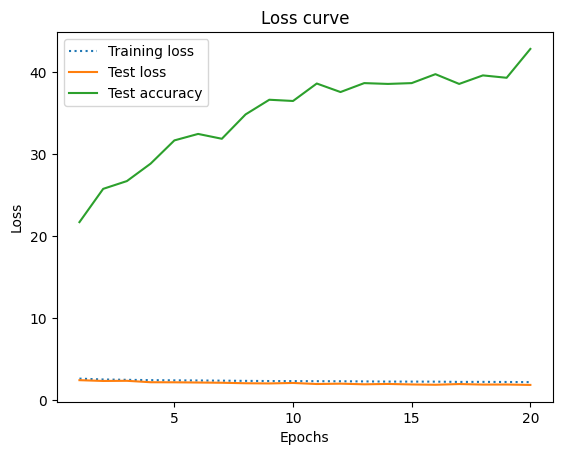

In [205]:
plot_curves(modifiedNetHistory, epochs)

In [206]:
modifiedNetTestResults = test(testloader, modifiedNet, criterion)

modifiedNetTestResults

{'val_loss': 2.1539, 'val_acc': 35.16}

In [30]:
torch.cuda.empty_cache()

In [31]:
class VGGClassifier(nn.Module):
    def __init__(self, ntargets=15):
        super(VGGClassifier, self).__init__()

        self.vgg = models.vgg16(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(self.vgg.classifier[6].in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, ntargets),
        )

        self.vgg.classifier[6] = self.fc

    def forward(self, x):
        x = self.vgg(x)
        return x

In [32]:
vggNet = VGGClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

vggNet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.5MB/s]


cuda:0


VGGClassifier(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [177]:
count_parameters(vggNet)

2106383

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggNet.parameters(), lr=0.00001)

In [34]:
epochs = 20
vggNetHistory = []

vggNetHistory += fit_and_evaluate(
    vggNet, trainloader, validloader, criterion, optimizer, epochs
)

Epoch 1
2.7815 2.4053 25.4
Epoch 2
2.5551 2.1694 34.03
Epoch 3
2.4396 2.0166 38.89
Epoch 4
2.3427 1.9074 42.66
Epoch 5
2.2958 1.8166 45.68
Epoch 6
2.249 1.755 47.57
Epoch 7
2.2127 1.7006 48.46
Epoch 8
2.1993 1.6564 49.75
Epoch 9
2.1757 1.6296 50.74
Epoch 10
2.1535 1.6095 51.19
Epoch 11
2.1261 1.5771 52.23
Epoch 12
2.1094 1.5564 52.63
Epoch 13
2.0909 1.5309 52.88
Epoch 14
2.1059 1.5115 53.12
Epoch 15
2.0831 1.4919 53.97
Epoch 16
2.0617 1.4868 54.07
Epoch 17
2.0484 1.4732 54.22
Epoch 18
2.0415 1.4514 54.96
Epoch 19
2.0395 1.4635 54.27
Epoch 20
2.0405 1.4322 54.51
------------------
Test Error: 
 Accuracy: 54.51%, Avg loss: 1.4322 



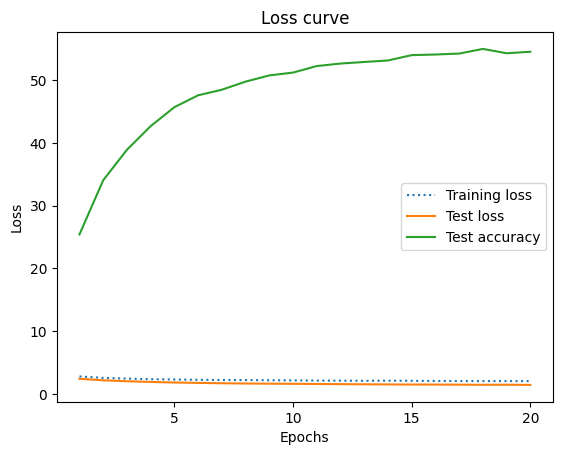

In [35]:
plot_curves(vggNetHistory, epochs)

In [36]:
vggNetTestResults = test(testloader, vggNet, criterion)

vggNetTestResults

{'val_loss': 1.4073, 'val_acc': 55.56}

In [184]:
torch.cuda.empty_cache()

In [162]:
class ResNetClassifier(nn.Module):
    def __init__(self, ntargets=15):
        super(ResNetClassifier, self).__init__()

        self.resnet = models.resnet34(pretrained=True, progress=True)
        # modules = list(resnet.children())[:-1]  # delete last layer
        # self.resnet = nn.Sequential(*modules)

        for param in self.resnet.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.resnet.fc.in_features),
            nn.Dropout(0.2),
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(256),
            # nn.Dropout(0.2),
            nn.Linear(512, ntargets),
        )

        self.resnet.fc = self.fc

    def forward(self, x):
        x = self.resnet(x)
        # x = self.fc(x)
        return x

In [163]:
resNet = ResNetClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

resNet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [180]:
count_parameters(resNet)

272399

In [164]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resNet.parameters(), lr=0.00001)

In [165]:
epochs = 20
resNetHistory = []

resNetHistory += fit_and_evaluate(
    resNet, trainloader, validloader, criterion, optimizer, epochs
)

Epoch 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2.8801 2.7417 9.82
Epoch 2
2.7573 2.6149 14.53
Epoch 3
2.6515 2.5009 20.93
Epoch 4
2.5722 2.4069 25.25
Epoch 5
2.4854 2.3198 27.88
Epoch 6
2.4244 2.2469 30.41
Epoch 7
2.3829 2.1749 33.93
Epoch 8
2.324 2.1163 35.47
Epoch 9
2.2798 2.0613 37.1
Epoch 10
2.2482 2.0165 39.38
Epoch 11
2.2104 1.9732 40.77
Epoch 12
2.1923 1.9328 41.96
Epoch 13
2.1573 1.8976 42.91
Epoch 14
2.1384 1.8758 43.95
Epoch 15
2.1042 1.8348 45.34
Epoch 16
2.0864 1.8158 45.54
Epoch 17
2.0733 1.7882 46.28
Epoch 18
2.05 1.7636 46.58
Epoch 19
2.0303 1.7367 47.07
Epoch 20
2.0055 1.7205 48.51
------------------
Test Error: 
 Accuracy: 48.51%, Avg loss: 1.7205 



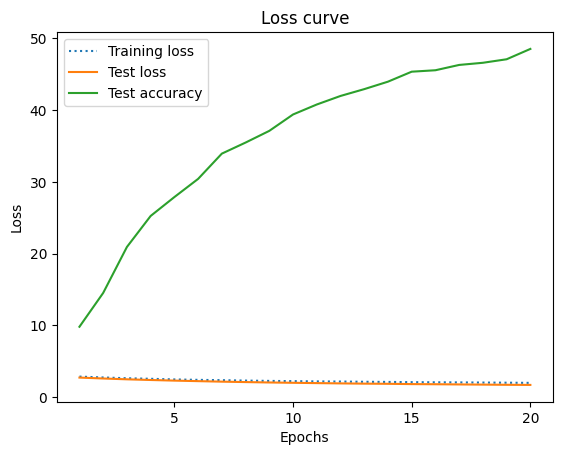

In [166]:
plot_curves(resNetHistory, epochs)

In [167]:
resNetTestResults = test(testloader, resNet, criterion)

resNetTestResults

{'val_loss': 1.7022, 'val_acc': 48.17}

In [168]:
torch.cuda.empty_cache()

In [169]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)


WeightsEnum.get_state_dict = get_state_dict


class EfficientNetClassifier(nn.Module):
    def __init__(self, ntargets=15):
        super(EfficientNetClassifier, self).__init__()

        self.efficientnet = models.efficientnet_b3(pretrained=True, progress=True)

        for param in self.efficientnet.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.efficientnet.classifier[1].in_features),
            nn.Dropout(0.2),
            nn.Linear(self.efficientnet.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, ntargets),
        )

        self.efficientnet.classifier = self.fc

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [170]:
efficientNet = EfficientNetClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

efficientNet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


EfficientNetClassifier(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
    

In [181]:
count_parameters(efficientNet)

798735

In [171]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientNet.parameters(), lr=0.00001)

In [172]:
epochs = 20
efficientNetHistory = []

efficientNetHistory += fit_and_evaluate(
    efficientNet, trainloader, validloader, criterion, optimizer, epochs
)

Epoch 1
2.7901 2.8558 15.82
Epoch 2
2.6149 2.4883 23.21
Epoch 3
2.4767 2.5149 28.77
Epoch 4
2.373 2.9645 33.13
Epoch 5
2.2873 2.5022 37.3
Epoch 6
2.2294 3.0994 39.48
Epoch 7
2.1767 2.2487 42.01
Epoch 8
2.115 2.0909 43.8
Epoch 9
2.1021 2.0366 45.59
Epoch 10
2.0577 1.8892 46.38
Epoch 11
2.025 1.9797 47.47
Epoch 12
2.0137 2.055 47.37
Epoch 13
1.9866 2.553 48.31
Epoch 14
1.9772 1.7344 49.75
Epoch 15
1.9348 1.8553 50.15
Epoch 16
1.9176 2.0924 50.84
Epoch 17
1.8999 1.8263 51.59
Epoch 18
1.9082 1.6865 52.68
Epoch 19
1.892 1.8872 52.43
Epoch 20
1.8646 1.8732 53.47
------------------
Test Error: 
 Accuracy: 53.47%, Avg loss: 1.8732 



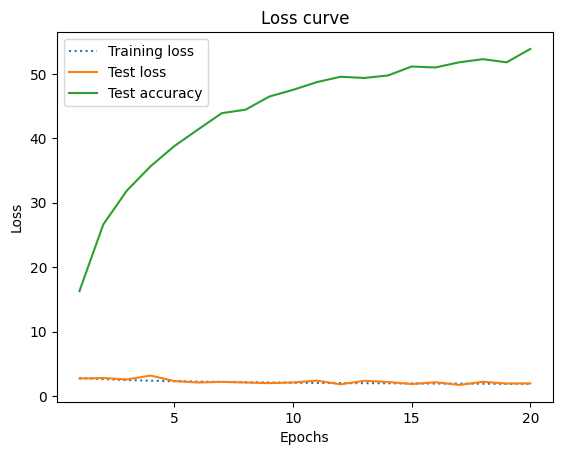

In [155]:
plot_curves(efficientNetHistory, epochs)

In [182]:
efficientNetTestResults = test(testloader, efficientNet, criterion)

efficientNetTestResults

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'val_loss': 1.621, 'val_acc': 52.1}

In [183]:
torch.cuda.empty_cache()

In [ ]:
pri

# PT

In [91]:
labels = dsUpdated["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [92]:
!pip install transformers
! pip install -U accelerate

In [93]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(
    checkpoint, ignore_mismatched_sizes=True
)

In [94]:
trainTransform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-45, 45)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.ToTensor(),
    ]
)

testTransform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Resize((224, 224)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.ToTensor(),
    ]
)


def trainTransformF(batch):
    inputs = image_processor(
        [img.convert("RGB") for img in batch["image"]], return_tensors="pt"
    )

    inputs["labels"] = batch["labels"]
    return inputs


def testTransformF(batch):
    inputs = image_processor(
        [img.convert("RGB") for img in batch["image"]], return_tensors="pt"
    )

    inputs["labels"] = batch["labels"]
    return inputs


dsUpdated["train"].set_transform(trainTransformF)
dsUpdated["valid"].set_transform(testTransformF)
# dsUpdated['test'].set_transform(testTransformF)

In [95]:
from transformers import DefaultDataCollator


def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }


torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [96]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [97]:
import evaluate

accuracy = evaluate.load("accuracy")


import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [98]:
import accelerate

accelerate.__version__

'0.24.1'

In [99]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

# model.classifier = torch.nn.Linear(model.classifier.in_features, len(labels))


training_args = TrainingArguments(
    output_dir="my_awesome_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dsUpdated["train"],
    eval_dataset=dsUpdated["valid"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

training_args.device

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda', index=0)

In [100]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,1.084900,0.892053,0.782738
2,0.248900,0.640310,0.822421
4,0.059200,0.607933,0.835813


TrainOutput(global_step=155, training_loss=0.5598032651409026, metrics={'train_runtime': 876.3419, 'train_samples_per_second': 46.009, 'train_steps_per_second': 0.177, 'total_flos': 3.075240417456292e+18, 'train_loss': 0.5598032651409026, 'epoch': 4.92})

In [101]:
model.save_pretrained("./")

image_processor.save_pretrained("./")

['./preprocessor_config.json']

In [106]:
torch.cuda.empty_cache()

In [107]:
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification


image_processor = AutoImageProcessor.from_pretrained("/content/")

model = AutoModelForImageClassification.from_pretrained("/content/")
model.to("cuda")


testPreds = []
with torch.no_grad():
    for i in range(len(dsUpdated["test"])):
        inputs = image_processor(dsUpdated["test"][i]["image"], return_tensors="pt").to(
            "cuda"
        )
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        testPreds.append(model.config.id2label[predicted_label])


testLabels = [
    model.config.id2label[dsUpdated["test"][i]["labels"]]
    for i in range(len(dsUpdated["test"]))
]

In [108]:
print(testPreds)
print(testLabels)

['running', 'texting', 'sitting', 'clapping', 'drinking', 'texting', 'fighting', 'cycling', 'fighting', 'hugging', 'texting', 'texting', 'eating', 'eating', 'cycling', 'dancing', 'texting', 'clapping', 'clapping', 'calling', 'drinking', 'clapping', 'listening_to_music', 'sitting', 'calling', 'listening_to_music', 'cycling', 'listening_to_music', 'sitting', 'clapping', 'using_laptop', 'dancing', 'calling', 'drinking', 'drinking', 'fighting', 'sitting', 'hugging', 'texting', 'fighting', 'clapping', 'using_laptop', 'dancing', 'sitting', 'listening_to_music', 'hugging', 'sitting', 'clapping', 'fighting', 'laughing', 'cycling', 'laughing', 'fighting', 'texting', 'using_laptop', 'sleeping', 'running', 'texting', 'calling', 'clapping', 'laughing', 'running', 'clapping', 'hugging', 'running', 'laughing', 'calling', 'eating', 'sleeping', 'drinking', 'running', 'cycling', 'sleeping', 'dancing', 'laughing', 'clapping', 'clapping', 'using_laptop', 'running', 'calling', 'sitting', 'running', 'sitti

In [109]:
from sklearn.metrics import classification_report

print(classification_report(testPreds, testLabels))

                    precision    recall  f1-score   support

           calling       0.65      0.84      0.73       130
          clapping       0.88      0.83      0.85       178
           cycling       0.96      0.98      0.97       165
           dancing       0.88      0.84      0.86       177
          drinking       0.85      0.90      0.87       157
            eating       0.90      0.92      0.91       165
          fighting       0.89      0.88      0.88       171
           hugging       0.82      0.90      0.86       153
          laughing       0.88      0.88      0.88       168
listening_to_music       0.66      0.79      0.72       141
           running       0.89      0.88      0.89       170
           sitting       0.79      0.61      0.69       216
          sleeping       0.89      0.83      0.86       181
           texting       0.77      0.66      0.71       195
      using_laptop       0.77      0.84      0.80       153

          accuracy                    

In [185]:
dsTrainTest

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

In [186]:
trainset = dsTrainTest["train"]
testset = dsTrainTest["test"]

In [187]:
batchSize = 64


trainTransform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-45, 45)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.ToTensor(),
    ]
)

testTransform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Resize((224, 224)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.ToTensor(),
    ]
)


def train_collate(batch):
    images = torch.stack([trainTransform(item["image"]) for item in batch])
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)

    return [images, labels]


def test_collate(batch):
    images = torch.stack([testTransform(item["image"]) for item in batch])
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)

    return [images, labels]


trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batchSize, shuffle=True, collate_fn=train_collate
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batchSize, shuffle=False, collate_fn=test_collate
)

In [188]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)


WeightsEnum.get_state_dict = get_state_dict


class EfficientNetClassifier(nn.Module):
    def __init__(self, ntargets=15):
        super(EfficientNetClassifier, self).__init__()

        self.efficientnet = models.efficientnet_b3(pretrained=True, progress=True)

        for param in self.efficientnet.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.efficientnet.classifier[1].in_features),
            nn.Dropout(0.2),
            nn.Linear(self.efficientnet.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, ntargets),
        )

        self.efficientnet.classifier = self.fc

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [189]:
efficientNet = EfficientNetClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

efficientNet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


EfficientNetClassifier(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
    

In [190]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientNet.parameters(), lr=0.00001)

In [191]:
epochs = 30
efficientNetHistory = []

efficientNetHistory += fit_and_evaluate(
    efficientNet, trainloader, validloader, criterion, optimizer, epochs
)

Epoch 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2.7876 2.8348 18.01
Epoch 2
2.5843 2.9207 29.32
Epoch 3
2.4301 2.7796 35.42
Epoch 4
2.3244 3.1495 39.93
Epoch 5
2.2455 2.854 42.26
Epoch 6
2.162 2.9301 43.35
Epoch 7
2.1167 2.1571 45.68
Epoch 8
2.0796 2.355 47.57
Epoch 9
2.0432 2.7107 49.75
Epoch 10
2.0047 2.1752 50.6
Epoch 11
1.9858 2.0966 50.84
Epoch 12
1.9579 1.7744 51.74
Epoch 13
1.9524 1.7327 52.43
Epoch 14
1.9174 1.9453 54.46
Epoch 15
1.8848 1.7651 53.42
Epoch 16
1.8877 1.9792 54.37
Epoch 17
1.864 1.6503 54.71
Epoch 18
1.8727 1.5449 55.16
Epoch 19
1.8452 1.5878 56.2
Epoch 20
1.8559 2.2451 55.8
Epoch 21
1.8142 2.2881 56.0
Epoch 22
1.8008 1.8826 56.7
Epoch 23
1.8204 1.7926 56.55
Epoch 24
1.8003 1.655 56.94
Epoch 25
1.8002 1.5256 57.54
Epoch 26
1.7656 1.4672 58.63
Epoch 27
1.7957 1.687 58.13
Epoch 28
1.7905 1.472 58.58
Epoch 29
1.7753 1.3935 58.73
Epoch 30
1.7492 1.4596 59.08
------------------
Test Error: 
 Accuracy: 59.08%, Avg loss: 1.4596 



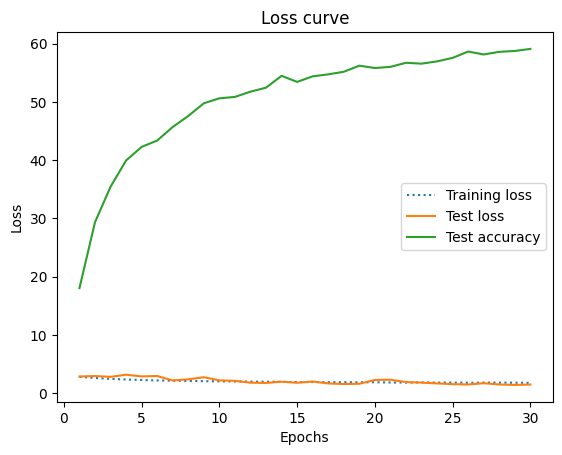

In [192]:
plot_curves(efficientNetHistory, epochs)

In [209]:
def finalTest(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    testPreds, testLabels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            pred = model(imgs)
            test_loss += loss_fn(pred, labels).item()
            _, pred = torch.max(pred.data, 1)

            testPreds.extend(pred)
            testLabels.extend(labels)
            correct += (pred == labels).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return (
        {"val_loss": round(test_loss, 4), "val_acc": round(correct * 100, 2)},
        testLabels,
        testPreds,
    )

In [210]:
efficientNetTestResults, effNetLabels, effNetPreds = finalTest(
    testloader, efficientNet, criterion
)

efficientNetTestResults

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'val_loss': 1.5941, 'val_acc': 56.63}

In [218]:
effNetPreds_cpu = [tensor.cpu().numpy() for tensor in effNetPreds]
effNetLabels_cpu = [tensor.cpu().numpy() for tensor in effNetLabels]


print(classification_report(effNetPreds_cpu, effNetLabels_cpu, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.38      0.45      0.41       142
          clapping       0.43      0.59      0.50       122
           cycling       0.87      0.76      0.81       192
           dancing       0.67      0.60      0.63       189
          drinking       0.46      0.71      0.56       108
            eating       0.77      0.65      0.71       197
          fighting       0.43      0.72      0.54       102
           hugging       0.33      0.68      0.44        81
          laughing       0.59      0.68      0.63       145
listening_to_music       0.41      0.38      0.39       183
           running       0.82      0.52      0.64       263
           sitting       0.60      0.36      0.45       281
          sleeping       0.65      0.67      0.66       162
           texting       0.39      0.53      0.45       123
      using_laptop       0.70      0.51      0.59       230

          accuracy                    